# Summary
Train some new embeddings (S2V, MS2DS), while leaving out spectra belonging to certain inchikeys.

In [2]:
import os
import gensim
import pickle
import time
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import Tuple, List
from copy import deepcopy

/mnt/scratch/louwe015/miniconda3/envs/spec_analysis8/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [41]:
data_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/datasets/ALL_GNPS_210409_positive/"
embedding_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/embeddings/ALL_GNPS_210409_positive/"

path_models = os.path.join(embedding_path, "cca_test_set")

train_inchis_file = os.path.join(path_models, "train_inchikeys.txt")
print(os.path.exists(train_inchis_file))

processed_spectrums_file = os.path.join(data_path, "ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v.pickle")
print(os.path.exists(processed_spectrums_file))

base = "ALL_GNPS_210409_positive_cleaned_peaks_processed"
print(base)

True
True
ALL_GNPS_210409_positive_cleaned_peaks_processed


## Filter out spectra
Only include spectra with inchikeys from train_inchikeys file

In [13]:
# read train_inchis_file
with open(train_inchis_file) as inf:
    line = inf.readline()
    train_inchikeys = line.strip(" ,").split(", ")  # strip comma from end
print(len(train_inchikeys))  # should be 7293

7293


In [14]:
train_inchikeys[:3], train_inchikeys[-3:]

(['IYDKWWDUBYWQGF', 'KNGPFNUOXXLKCN', 'CGZKSPLDUIRCIO'],
 ['PWAOOJDMFUQOKB', 'QRYRORQUOLYVBU', 'KBPHJBAIARWVSC'])

In [10]:
# read processed spectra
spectrums_processed = pickle.load(open(processed_spectrums_file, 'rb'))

In [12]:
len(spectrums_processed)

199780

In [16]:
spectrums_filtered = []
set_inchi14_train = set(train_inchikeys)
for spec in spectrums_processed:
    inchikey = spec.metadata.get("inchikey")
    if inchikey:
        if inchikey[:14] in set_inchi14_train:
            spectrums_filtered.append(spec)
len(spectrums_filtered)

79475

In [17]:
# check to see if same amount (7293) of inchikeys still exist
len(set(spec.metadata.get("inchikey")[:14] for spec in spectrums_filtered if spec.metadata.get("inchikey")))

7293

## Spec2Vec

In [18]:
from spec2vec import SpectrumDocument
documents_spectrums_filtered = [SpectrumDocument(s, n_decimals=2) for s in spectrums_filtered]

In [19]:
from spec2vec.model_building import train_new_word2vec_model
import glob

model_file = os.path.join(path_models, base+"_only_train_spec2vec_embedding.model")
print(model_file)

find_model = glob.glob(os.path.join(path_models, base+"_only_train_spec2vec*"))
if len(find_model) == 0:
    iterations = [15]
    # Train model with default parameters
    model = train_new_word2vec_model(documents_spectrums_filtered, iterations, model_file)

/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/datasets/ALL_GNPS_210409_positive/ALL_GNPS_210409_positive_cleaned_peaks_processed_spec2vec_embedding.model
  Epoch 1 of 15.Change in loss after epoch 1: 3521952.75
  Epoch 2 of 15.Change in loss after epoch 2: 2881441.75
  Epoch 3 of 15.Change in loss after epoch 3: 2442946.5
  Epoch 4 of 15.Change in loss after epoch 4: 2096941.0
  Epoch 5 of 15.Change in loss after epoch 5: 2107511.0
  Epoch 6 of 15.Change in loss after epoch 6: 2002219.0
  Epoch 7 of 15.Change in loss after epoch 7: 1905996.0
  Epoch 8 of 15.Change in loss after epoch 8: 1492440.0
  Epoch 9 of 15.Change in loss after epoch 9: 1492570.0
  Epoch 10 of 15.Change in loss after epoch 10: 1427834.0
  Epoch 11 of 15.Change in loss after epoch 11: 1331980.0
  Epoch 12 of 15.Change in loss after epoch 12: 1307482.0
  Epoch 13 of 15.Change in loss after epoch 13: 1275600.0
  Epoch 14 of 15.Change in loss after epoch 14: 1205648.0
  Epoch 15 of 15.Change in loss after epoch 

## MS2DeepScore (10000 -> 500 -> 500 = 200)
Currently I trained without validation data, but put 40 epochs of training analogous to MS2Query model.

1130


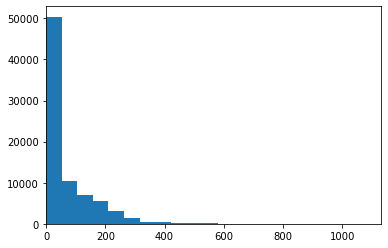

In [23]:
numbers_of_peaks = [len(s.peaks) for s in spectrums_filtered]
plt.hist(numbers_of_peaks, np.linspace(0,1000,20))
plt.xlim(0, max(numbers_of_peaks))

print(max(numbers_of_peaks))
plt.show()

In [28]:
# load tanimoto scores
tanimoto_file = os.path.join(data_path, "ALL_GNPS_210409_positive_tanimoto_scores.pickle")
print(os.path.exists(tanimoto_file))
tanimoto_scores_df = pickle.load(open(tanimoto_file, 'rb'))
tanimoto_scores_df

True


,STZYTFJPGGDRJD,SWTDXMBCOHIACK,HJBWJAPEBGSQPR,VQNWOYVWHDVFJY,WFDXOXNFNRHQEC,GZLIPAFSJXROEC,YTZSBJLNMIQROD,FOULCGVQZYQEQM,BPSJMBKZSUTYNF,PZJVSTTVMXPZCJ,...,VLSRUFWCGBMYDJ,SXXHPCVDFDABHW,MRHAPHFJBAUDTR,ZYCWGZVLCXRARB,CGUNOWXWUXNOPE,MGRVRXRGTBOSHW,WELCNKRQSNXMDQ,XFANDVLPSBUGKD,NDTYTMIUWGWIMO,OAUIRSVJXOFAOO
STZYTFJPGGDRJD,1.000000,0.377404,0.124056,0.269856,0.233411,0.258824,0.354221,0.227136,0.277537,0.316971,...,0.112832,0.177950,0.277099,0.308905,0.341988,0.017219,0.274643,0.298611,0.138404,0.270531
SWTDXMBCOHIACK,0.377404,1.000000,0.158318,0.274962,0.297240,0.324305,0.372534,0.216172,0.274742,0.351300,...,0.140399,0.184380,0.325533,0.353607,0.387618,0.014911,0.364401,0.371447,0.153314,0.366841
HJBWJAPEBGSQPR,0.124056,0.158318,1.000000,0.159198,0.209205,0.200203,0.133133,0.106944,0.201604,0.157643,...,0.753012,0.152395,0.180529,0.188280,0.147473,0.005848,0.199245,0.234842,0.074725,0.180833
VQNWOYVWHDVFJY,0.269856,0.274962,0.159198,1.000000,0.270677,0.261011,0.218063,0.237487,0.228497,0.471683,...,0.149272,0.216159,0.591716,0.370402,0.279240,0.014306,0.288416,0.314224,0.100515,0.262040
WFDXOXNFNRHQEC,0.233411,0.297240,0.209205,0.270677,1.000000,0.329466,0.273837,0.184561,0.258525,0.355102,...,0.194030,0.212011,0.330603,0.312870,0.318026,0.017301,0.319708,0.357045,0.083333,0.351071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGRVRXRGTBOSHW,0.017219,0.014911,0.005848,0.014306,0.017301,0.017957,0.011792,0.035644,0.013072,0.018998,...,0.006536,0.015625,0.014568,0.013684,0.010919,1.000000,0.016327,0.015598,0.018957,0.016904
WELCNKRQSNXMDQ,0.274643,0.364401,0.199245,0.288416,0.319708,0.498774,0.291818,0.206495,0.290592,0.360465,...,0.178606,0.203997,0.346317,0.368841,0.374494,0.016327,1.000000,0.413747,0.113171,0.409401
XFANDVLPSBUGKD,0.298611,0.371447,0.234842,0.314224,0.357045,0.368529,0.304927,0.201923,0.318118,0.425359,...,0.197961,0.218633,0.381903,0.373005,0.397096,0.015598,0.413747,1.000000,0.092946,0.407524
NDTYTMIUWGWIMO,0.138404,0.153314,0.074725,0.100515,0.083333,0.115589,0.146286,0.143836,0.090047,0.093234,...,0.073460,0.069132,0.089494,0.114688,0.134598,0.018957,0.113171,0.092946,1.000000,0.086003


In [32]:
from ms2deepscore import SpectrumBinner
spectrum_binner = SpectrumBinner(10000, mz_min=10.0, mz_max=1000.0, peak_scaling=0.5,
                                 allowed_missing_percentage=10.0)
binned_spectrums = spectrum_binner.fit_transform(spectrums_filtered)

Collect spectrum peaks...
Calculated embedding dimension: 9881.
Convert spectrums to binned spectrums...


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████| 79475/79475 [00:01<00:00, 43986.89it/s]


In [33]:
from ms2deepscore.data_generators import DataGeneratorAllSpectrums, DataGeneratorAllInchikeys
dimension = len(spectrum_binner.known_bins)
# data_generator = DataGeneratorAllSpectrums(binned_spectrums, tanimoto_scores_df,
#                                            dim=dimension)


same_prob_bins = list(zip(np.linspace(0,0.9,10), np.linspace(0.1,1,10)))

selected_inchikeys = np.unique([s.get("inchikey")[:14] for s in spectrums_filtered])
        
data_generator = DataGeneratorAllInchikeys(binned_spectrums, selected_inchikeys,
                                           tanimoto_scores_df,
                                           dim=dimension,
                                           same_prob_bins=same_prob_bins,
                                           num_turns=2,
                                           augment_noise_max=10,
                                           augment_noise_intensity=0.01)

The value for num_turns is set from 1 (default) to 2
The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_noise_max is set from 10 (default) to 10
The value for augment_noise_intensity is set from 0.01 (default) to 0.01


In [34]:
from tensorflow import keras
from ms2deepscore.models import SiameseModel

ms2ds_model = SiameseModel(spectrum_binner, base_dims=[500, 500], embedding_dim=200,
                           dropout_rate=0.2)
ms2ds_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 9881)]            0         
                                                                 
 dense1 (Dense)              (None, 500)               4941000   
                                                                 
 normalization1 (BatchNormal  (None, 500)              2000      
 ization)                                                        
                                                                 
 dense2 (Dense)              (None, 500)               250500    
                                                                 
 normalization2 (BatchNormal  (None, 500)              2000      
 ization)                                                        
                                                                 
 dropout2 (Dropout)          (None, 500)               0      

In [37]:
ms2ds_model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
ms2ds_model.fit(
    data_generator,
    validation_data=data_generator,
    epochs=40)  # could also make some validation data and include early stopping etc?

/mnt/scratch/louwe015/miniconda3/envs/spec_analysis8/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
454/454 [==============================] - 110s 238ms/step - loss: 0.1022 - val_loss: 0.0945
Epoch 2/40
454/454 [==============================] - 109s 241ms/step - loss: 0.0940 - val_loss: 0.0907
Epoch 3/40
454/454 [==============================] - 110s 243ms/step - loss: 0.0908 - val_loss: 0.0892
Epoch 4/40
454/454 [==============================] - 112s 247ms/step - loss: 0.0884 - val_loss: 0.0855
Epoch 5/40
454/454 [==============================] - 111s 246ms/step - loss: 0.0859 - val_loss: 0.0842
Epoch 6/40
454/454 [==============================] - 110s 243ms/step - loss: 0.0859 - val_loss: 0.0836
Epoch 7/40
454/454 [==============================] - 109s 241ms/step - loss: 0.0830 - val_loss: 0.0807
Epoch 8/40
454/454 [==============================] - 108s 237ms/step - loss: 0.0826 - val_loss: 0.0809
Epoch 9/40
454/454 [==============================] - 108s 239ms/step - loss: 0.0827 - val_loss: 0.0799
Epoch 10/40
454/454 [==============================] - 111s 245m

In [42]:
ms2ds_model_out = os.path.join(path_models, base+"_only_train_ms2ds_10k_500_500_200.hdf5")
ms2ds_model.save(ms2ds_model_out)

In [43]:
from ms2deepscore import MS2DeepScore
ms2ds_score = MS2DeepScore(ms2ds_model)

In [47]:
ms2ds_score.model.spectrum_binner.allowed_missing_percentage = 50
ms2ds_score.model.spectrum_binner.allowed_missing_percentage

50

### code from ms2query for including validation data and early stopping

In [ ]:
# # Save best model and include early stopping
# epochs = 150
# learning_rate = 0.001
# import tensorflow as tf
# metrics = ["mae", tf.keras.metrics.RootMeanSquaredError()]

# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from datetime import datetime
# timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# # Parameters
# patience_scoring_net = 5
# embedding_dim = 200
# filename_base = f"{timestamp}_data210409_10k_500_500_{embedding_dim}"
# model_output_file = os.path.join(path_data, "trained_models" , filename_base+".hdf5")

# model.compile(
#     loss='mse',
#     optimizer=Adam(lr=learning_rate),
#     metrics=metrics)

# checkpointer = ModelCheckpoint(
#     filepath = model_output_file,
#     monitor='val_loss', mode="min",
#     verbose=1,
#     save_best_only=True
#     )

# earlystopper_scoring_net = EarlyStopping(
#     monitor='val_loss', mode="min",
#     patience=patience_scoring_net,
#     verbose=1
#     )

# history = model.model.fit(training_generator,
#     validation_data=validation_generator,
#     epochs = epochs,
#     verbose=1, 
#     callbacks = [
#         earlystopper_scoring_net,
#         checkpointer,
#         ]
#     )

# # Save history
# filename = os.path.join(path_output, filename_base+'_training_history.pickle')
# with open(filename, 'wb') as f:
#     pickle.dump(history.history, f)